# SVD tronquée

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

Examinons le cas où on cherche à déterminer le mouvement du sol suite au passage d'une onde sismique, à partir de l'enregistrement réalisé à un sismomètre.  Le sismomètre est caractérisé par sa réponse impulsionnelle, qui est le signal qu'on mesurerait si le mouvement du sol était une impulsion.  La réponse impulsionnelle d'un sismomètre ayant une constante de temps $T_0$ et un gain de $g_0$ peut être décrite par la fonction suivante:

\begin{equation}
g(t) = \left\lbrace \begin{matrix}
g_0 t e^{-t/T_0}\qquad (t\geq 0) \\
0\qquad\qquad (t<0)
\end{matrix}\right.
\end{equation}

La figure suivante montre la réponse pour une impulsion unitaire de 1 m/s$^2\cdot$s

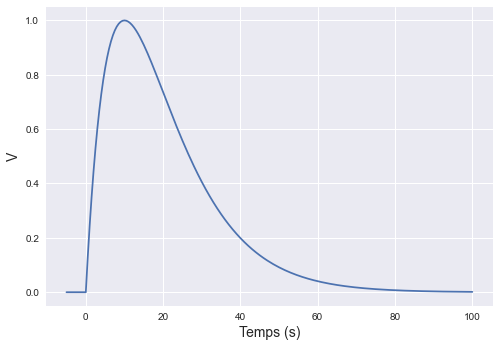

In [2]:
# variance du bruit
noise = 0.05
# taille du problème
N = 211
M = 211

T0 = 10

t = np.linspace(-5, 100, N)
g = np.zeros(t.shape)
g[t>0] = t[t>0] * np.exp(-t[t>0]/T0)

gmax = np.max(g)
g0 = 1/gmax      # g0 choisi pour avoir une sortie max de 1V
g *= g0

plt.plot(t, g)
plt.xlabel('Temps (s)', fontsize=14)
plt.ylabel('V', fontsize=14)
plt.show()

Si le mouvement du sol suit une fonction $m_{vrai}(t)$ donnée, le voltage $v(t)$ mesuré au sismomètre sera la convolution de $g(t)$ avec cette fonction, i.e.
\begin{equation}
v(t) = \int_{-\infty}^{\infty}g(\tau-t)m_{vrai}(\tau)d\tau
\end{equation}

L'objectif est donc de faire la déconvolution du signal de sortie pour éliminer l'effet de la réponse impulsionnelle.  L'équation précédente peut être discrétisée pour obtenir un système de la forme
\begin{equation}
\mathbf{d} = \mathbf{Gm}
\end{equation}
où
\begin{equation}
G_{i,j} = \left\lbrace \begin{matrix}
(t_i-t_j) e^{-(t_i-t_j)/T_0} \Delta t\qquad (t_i\geq t_j) \\
0\qquad\qquad (t_i<t_j)
\end{matrix}\right.
\end{equation}




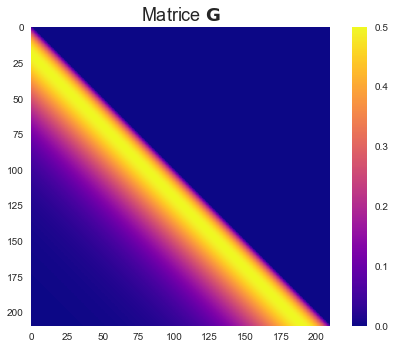

In [3]:
G = np.zeros((M-1,N-1))
for i in range(1, M):
    for j in range(N-1):
        tp = t[j]-t[i]
        if (tp <= 0):
            G[i-1,j] = -tp * np.exp(tp/T0)

deltat = t[1] - t[0]
G = G/gmax*deltat

plt.imshow(G, cmap='plasma')
plt.colorbar()
plt.grid()
plt.title('Matrice $\mathbf{G}$', fontsize=18)
plt.show()

On peut maintenant procéder à la décomposition en valeurs singulières, et examiner le spectre des valeurs.

25.171880189699127 0.016979594095829036 1482.478323547351


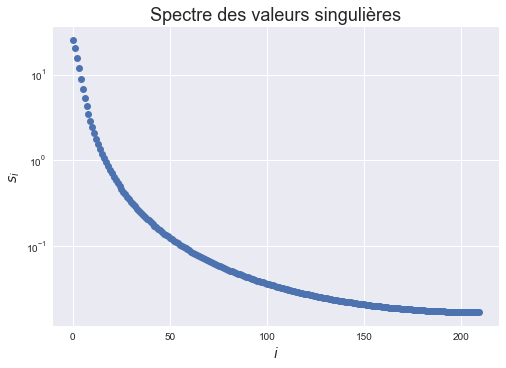

In [4]:
U, s, Vh = np.linalg.svd(G)
V = Vh.T
S = np.diag(s)

cond = s[0] / s[-1]

print(s[0], s[-1], cond)

plt.semilogy(s, 'o')
plt.xlabel('$i$', fontsize=14)
plt.ylabel('$s_i$', fontsize=14)
plt.title('Spectre des valeurs singulières', fontsize=18)
plt.show()

Les valeurs singulières sont comprises entre 25.2 et 0.017, ce qui donne un conditionnement de plus de 1482.  Le système n'est pas très bien conditionné.  Voyons la réponse du sismomètre à un mouvement du sol comportant deux accélérations de forme gaussienne ayant une largeur de $\sigma$ = 2 s, l'une centrée à $t$ = 8 s et l'autre centrée à $t$ = 25, i.e.

\begin{equation}
m_{vrai}(t) = e^{-(t-8)^2/(2\sigma^2)} + 0.5 e^{-(t-25)^2/(2\sigma^2)}
\end{equation}

On peut calculer le voltage qui serait mesuré en l'absence de bruit, i.e.

\begin{equation}
\mathbf{d}_{vrai} = \mathbf{G}\mathbf{m}_{vrai}
\end{equation}

et ajouter un bruit gaussien pour obtenir le voltage qui serait mesuré dans des conditions plus réalistes.

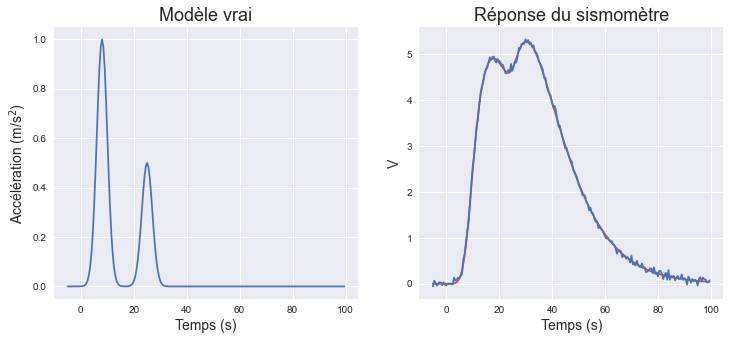

In [5]:
sigma = 2
mtrue = np.exp(-(t[:-1]-8)**2 / (2*sigma*sigma)) + 0.5 * np.exp(-(t[:-1]-25)**2 / (2*sigma*sigma))

# mise à l'échelle
mtrue = mtrue / mtrue.max()

d = G @ mtrue

# ajout du bruit
dn = d + 0.05 * np.random.randn(N-1)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(t[:-1], mtrue)
plt.xlabel('Temps (s)', fontsize=14)
plt.ylabel('Accélération (m/s$^2$)', fontsize=14)
plt.title('Modèle vrai', fontsize=18)

plt.subplot(122)
plt.plot(t[:-1], d, c='C2')
plt.plot(t[:-1], dn, c='C0')
plt.xlabel('Temps (s)', fontsize=14)
plt.ylabel('V', fontsize=14)
plt.title('Réponse du sismomètre', fontsize=18)

plt.show()


Voyons le modèle estimé avec l'inverse généralisé en utilisant la totalité des valeurs singulières.

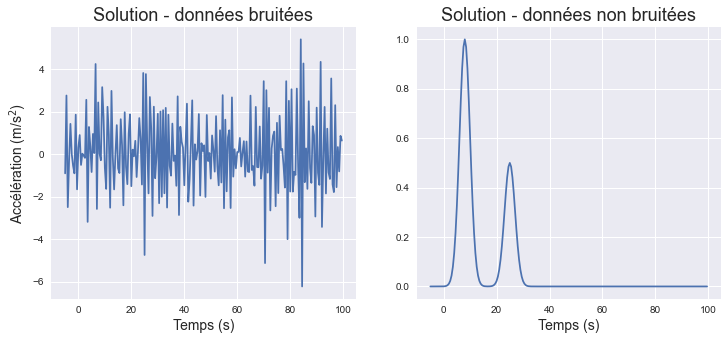

In [6]:
Up = U
Sp = S
Vp = V

Gi = Vp.dot(np.linalg.inv(Sp).dot(Up.T))


mn = Gi @ dn
mparfait = Gi @ d

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(t[:-1], mn)
plt.xlabel('Temps (s)', fontsize=14)
plt.ylabel('Accélération (m/s$^2$)', fontsize=14)
plt.title('Solution - données bruitées', fontsize=18)

plt.subplot(122)
plt.plot(t[:-1], mparfait)
plt.xlabel('Temps (s)', fontsize=14)
plt.title('Solution - données non bruitées', fontsize=18)

plt.show()

On peut voir que le bruit est amplifié considérablement par l'inversion et que la solution obtenue à partir des données bruitées est complètement inutilisable.

Quel est le résultat si on élimine une partie des valeurs singulières?  Voyons d'abord la courbe de $\|\mathbf{Gm}-\mathbf{d}\|_2$ en fonction de $\|\mathbf{m}\|_2$ pour un nombre croissant de valeurs singulières.

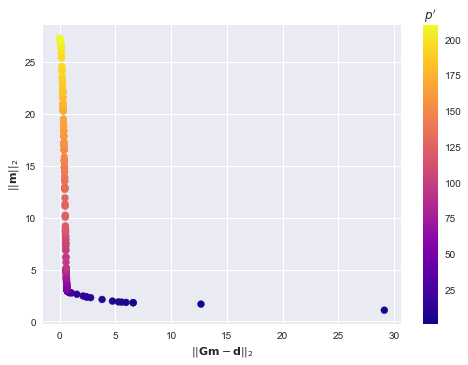

In [7]:
pmax = np.linalg.matrix_rank(G)
m = np.zeros((N-1,))

r = np.empty((pmax,))
mnorm = np.empty((pmax,))
for i in range(pmax):
    m += (U[:,i].T.dot(dn) / s[i]) * V[:,i]
    res = G.dot(m) - dn
    r[i] = np.linalg.norm(res)
    mnorm[i] = np.linalg.norm(m)
    
plt.scatter(r, mnorm, c=np.arange(1,pmax+1), cmap='plasma')
plt.xlabel('$||\mathbf{Gm}-\mathbf{d}||_2$')
plt.ylabel('$||\mathbf{m}||_2$')
clb = plt.colorbar()
clb.ax.set_title('$p\'$')
plt.show()

On a un bon compromis pour $p'$ = 26.  Voyons la solution pour une troncation à cette valeur.

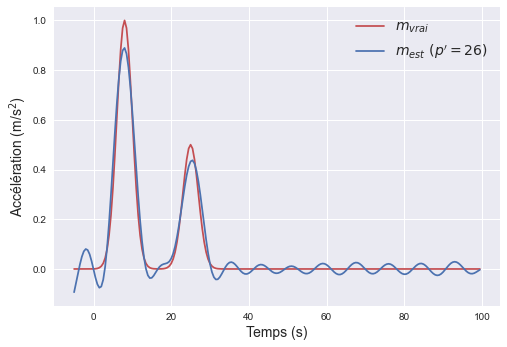

In [8]:
Up = U[:,:26]
Sp = S[:26,:26]
Vp = V[:,:26]

Gi = Vp.dot(np.linalg.inv(Sp).dot(Up.T))

m2 = Gi @ dn

plt.plot(t[:-1], mparfait, c='C2', label='$m_{vrai}$')

plt.plot(t[:-1], m2, c='C0', label='$m_{est}\ (p\'=26)$')
plt.legend(fontsize=14)
plt.xlabel('Temps (s)', fontsize=14)
plt.ylabel('Accélération (m/s$^2$)', fontsize=14)

plt.show()

On retrouve les deux pics d'accélération, mais avec une légère perte de résolution (largeur un peu plus grande et amplitude réduite) et la présence d'oscillations parasites.  Ces effets sont typiques d'une solution obtenue avec une troncation, et peuvent être prévisibles en examinant la matrice de résolution du modèle.

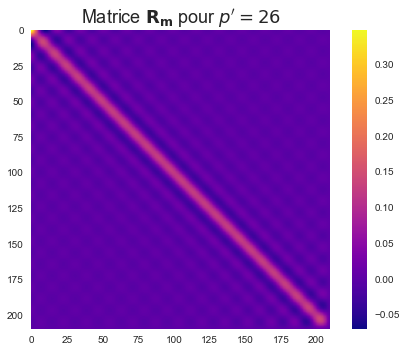

In [9]:
Rm = Vp @ Vp.T

plt.imshow(Rm, cmap='plasma')
plt.colorbar()
plt.grid()
plt.title('Matrice $\mathbf{R_m}$ pour $p\'=26$', fontsize=18)
plt.show()